In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import json, math, random
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import functools
from functools import partial

In [ ]:
def make_loader_for_mode(cfg: TrainConfig, split: str, mode: str) -> DataLoader:
    ds = MazeMCQDataset._load_one(cfg, split, mode)  
    return DataLoader(
        ds, batch_size=cfg.batch_size, shuffle=False,
        num_workers=0,  
        pin_memory=False,
        collate_fn=partial(collate_maze, pad_id=cfg.pad_id)
    )

@torch.no_grad()
def evaluate_loader(model: nn.Module, loader: DataLoader, device: str) -> Tuple[float, float]:
    model.eval()
    n, correct, total_loss = 0, 0, 0.0
    for batch in loader:
        x = {k:(v.to(device) if isinstance(v, torch.Tensor) else v) for k,v in batch.items()}
        logits = model(x["prefix_ids"], x["attn_mask"], x["choices_ids"])
        loss = F.cross_entropy(logits, x["labels"]) 
        pred = logits.argmax(dim=-1)
        correct += (pred == x["labels"]).sum().item()
        total_loss += loss.item() * logits.size(0)
        n += logits.size(0)
    return correct/max(n,1), total_loss/max(n,1)

def report_by_mode(model: nn.Module, cfg: TrainConfig, split: str, header: str = "") -> Dict[str, Tuple[float,float]]:
    results = {}
    modes = _ALL_MODES
    rows = []
    for m in modes:
        try:
            ld = make_loader_for_mode(cfg, split, m)
        except FileNotFoundError:
            continue
        acc, los = evaluate_loader(model, ld, cfg.device)
        results[m] = (acc, los)
        rows.append((m, f"{acc:.3f}", f"{los:.3f}"))
    if rows:
        print(header or f"[{split.upper()}] by mode")
        print("mode\tacc\tloss")
        for r in rows:
            print("\t".join(r))
    return results

In [ ]:

_MODE_ALIASES = {
    "rulemap": "rulemap", "random": "random", "logic": "logic",
    "intermediate_case1": "intermediate_case1", "intermediate_case2": "intermediate_case2",
    "intermediate_1": "intermediate_case1", "intermediate_2": "intermediate_case2",
    "intemediete_1": "intermediate_case1", "intemediete_2": "intermediate_case2",
    "intermediat_case1": "intermediate_case1", "intermediat_case2": "intermediate_case2",
    "all": "all",
}
_SPLIT_DIR = {"train":"training_data","val":"validation_data","test":"testing_data"}
_ALL_MODES = ["rulemap","random","logic","intermediate_case1","intermediate_case2"]

@dataclass
class TrainConfig:
    data_root: Path                   
    sim_name: str = "sim1"
    mode: str = "all"                 
    pad_id: int = 576                 
    cls_id: int = 577                 
    add_cls: bool = True

    # model
    vocab_size: int = 578             
    d_model: int = 256
    nhead: int = 8
    n_layers: int = 4
    dim_ff: int = 1024
    dropout: float = 0.1
    e_char_dim: int = 64         

    # train
    batch_size: int = 64
    lr: float = 3e-4
    weight_decay: float = 1e-2
    max_epochs: int = 30
    seed: int = 42
    num_workers: int = 4
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    def canonical_mode(self) -> str:
        key = self.mode.strip().lower()
        if key not in _MODE_ALIASES:
            raise ValueError(f"Unknown mode: {self.mode}")
        return _MODE_ALIASES[key]

def csv_paths(cfg: TrainConfig, split: str, mode: str) -> Tuple[Path, Path]:
    base = cfg.data_root / _SPLIT_DIR[split] / cfg.sim_name / "csv"
    return base / f"{mode}_train.csv", base / f"{mode}_answers.csv"

# =============== Dataset / Collate =================
class MazeMCQDataset(Dataset):
    """
    一個樣本:
    - prefix_ids: Long[L] (可含 CLS)
    - choices_ids: Long[4,3]
    - label: Long[] in {0,1,2,3}
    - meta: trial_id/mode/seq_len_T/case_type
    """
    def __init__(self, df: pd.DataFrame, pad_id: int, cls_id: int, add_cls: bool):
        self.df = df.reset_index(drop=True)
        self.pad_id, self.cls_id, self.add_cls = pad_id, cls_id, add_cls
        self.letter2idx = {"A":0,"B":1,"C":2,"D":3}

    @staticmethod
    def _load_one(cfg: TrainConfig, split: str, mode: str) -> "MazeMCQDataset":
        t_csv, a_csv = csv_paths(cfg, split, mode)
        if not t_csv.exists() or not a_csv.exists():
            raise FileNotFoundError(f"Missing: {t_csv} / {a_csv}")
        t = pd.read_csv(t_csv)
        a = pd.read_csv(a_csv)
        common = sorted(set(t["trial_id"]).intersection(set(a["trial_id"])))
        df = t[t["trial_id"].isin(common)].merge(a[a["trial_id"].isin(common)], on=["trial_id","mode"], how="inner")
        return MazeMCQDataset(df, cfg.pad_id, cfg.cls_id, cfg.add_cls)

    @staticmethod
    def load(cfg: TrainConfig, split: str) -> "MazeMCQDataset":
        cmode = cfg.canonical_mode()
        if cmode != "all":
            return MazeMCQDataset._load_one(cfg, split, cmode)
        parts = []
        for m in _ALL_MODES:
            ds_m = MazeMCQDataset._load_one(cfg, split, m)
            parts.append(ds_m.df)
        df_all = pd.concat(parts, axis=0, ignore_index=True)
        return MazeMCQDataset(df_all, cfg.pad_id, cfg.cls_id, cfg.add_cls)

    def __len__(self): return len(self.df)

    def _parse_cells(self, s: str) -> List[int]:
        arr = json.loads(s)
        assert all(isinstance(x,int) and 0<=x<=575 for x in arr), "cid out of range"
        return arr

    def __getitem__(self, i: int) -> Dict:
        r = self.df.iloc[i]
        # prefix
        prefix = self._parse_cells(r["cell_json"])
        if self.add_cls:
            prefix = [self.cls_id] + prefix

        # choices
        ch = []
        for c in "ABCD":
            vec = self._parse_cells(r[f"choice{c}_cell"])
            assert len(vec) == 3
            ch.append(torch.tensor(vec, dtype=torch.long))
        choices = torch.stack(ch, dim=0)  # [4,3]

        label = torch.tensor({"A":0,"B":1,"C":2,"D":3}[r["correct"]], dtype=torch.long)
        meta = {
            "trial_id": r["trial_id"], "mode": r["mode"],
            "seq_len_T": int(r["seq_len_T"]),
            "case_type": "" if pd.isna(r.get("case_type","")) else str(r.get("case_type","")),
        }
        return {
            "prefix_ids": torch.tensor(prefix, dtype=torch.long),  # [L]
            "choices_ids": choices,                                # [4,3]
            "label": label, "meta": meta,
        }

def collate_maze(batch: List[Dict], pad_id: int) -> Dict[str, torch.Tensor]:
    B = len(batch)
    lengths = [len(b["prefix_ids"]) for b in batch]
    L = max(lengths)
    prefix = torch.full((B,L), pad_id, dtype=torch.long)
    mask   = torch.zeros((B,L), dtype=torch.bool)  # True=keep
    for i,b in enumerate(batch):
        li = len(b["prefix_ids"])
        prefix[i,:li] = b["prefix_ids"]
        mask[i,:li] = True
    choices = torch.stack([b["choices_ids"] for b in batch], dim=0)  # [B,4,3]
    labels  = torch.stack([b["label"] for b in batch], dim=0)
    meta = {k:[b["meta"][k] for b in batch] for k in batch[0]["meta"].keys()}
    return {"prefix_ids":prefix, "attn_mask":mask, "choices_ids":choices, "labels":labels, "meta":meta}

# =============== Positional Encoding（sinusoidal） =================
class SinusoidalPosEnc(nn.Module):
    def __init__(self, d_model: int, max_len: int = 4096):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)  # [max_len, d_model]
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B,L,d]
        L = x.size(1)
        return x + self.pe[:L].unsqueeze(0)

# =============== ：CharNet（Transformer） + PredNet =================
class CharNet(nn.Module):
    def __init__(self, vocab_size:int, d_model:int, nhead:int, n_layers:int, dim_ff:int, dropout:float, e_char_dim:int, pad_id:int, cls_id:int, use_cls:bool):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos_enc = SinusoidalPosEnc(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                               dim_feedforward=dim_ff, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.ln = nn.LayerNorm(d_model)
        self.proj = nn.Linear(d_model, e_char_dim)
        self.cls_id = cls_id
        self.use_cls = use_cls

    def forward(self, prefix_ids: torch.Tensor, attn_mask: torch.Tensor) -> torch.Tensor:
        """
        prefix_ids: [B,L], attn_mask: [B,L] (True=keep, False=pad)
        return: e_char [B, e_char_dim]
        """
        x = self.tok_emb(prefix_ids)         # [B,L,d]
        x = self.pos_enc(x)                  # sinusoidal
        key_padding = ~attn_mask             # True=PAD for PyTorch
        h = self.encoder(x, src_key_padding_mask=key_padding)  # [B,L,d]
        h = self.ln(h)
        if self.use_cls:
            # 取第一個 token（CLS）
            e_src = h[:,0,:]                 # [B,d]
        else:
            # masked mean pool
            m = attn_mask.unsqueeze(-1)      # [B,L,1]
            e_src = (h * m).sum(dim=1) / (m.sum(dim=1).clamp_min(1.0))
        e_char = self.proj(e_src)            # [B,e_char]
        return e_char                        # e_char

class PredNet(nn.Module):
    """
    PredNet: h_phi(e_char, q) -> scores over 4 choices
    - q_vec: 取 prefix 最後 3 個有效 token 的嵌入均值（query 狀態），再線性投影
    - choice_vec: 每個候選 3 token 嵌入均值 + 投影（共享）
    - fuse: prefix_fused = LN(W_e * e_char + W_q * q_vec)
    - score_i = MLP([prefix_fused ; choice_vec_i ; |diff| ; hadamard])
    """
    def __init__(self, tok_emb: nn.Embedding, d_model:int, e_char_dim:int, dropout:float):
        super().__init__()
        self.tok_emb = tok_emb
        self.proj_e = nn.Linear(e_char_dim, d_model)
        self.proj_q = nn.Linear(d_model, d_model)
        self.proj_choice = nn.Linear(d_model, d_model)
        self.ln = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(4*d_model, 2*d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2*d_model, 1)
        )

    def _embed_avg(self, ids: torch.Tensor) -> torch.Tensor:
        # ids: [..., K]
        emb = self.tok_emb(ids)      # [..., K, d]
        return emb.mean(dim=-2)      # [..., d]

    def forward(self, e_char: torch.Tensor, prefix_ids: torch.Tensor, attn_mask: torch.Tensor, choices_ids: torch.Tensor) -> torch.Tensor:
        """
        e_char: [B,e]
        prefix_ids: [B,L], attn_mask: [B,L]
        choices_ids: [B,4,3]
        return: logits [B,4]
        """
        B, L = prefix_ids.shape
        # q_vec：取每個 batch 最後 3 個有效 token
        last_idx = attn_mask.sum(dim=1) - 1               # [B] 最後一個有效位置
        idxs = torch.stack([last_idx-2, last_idx-1, last_idx], dim=1).clamp_min(0)  # [B,3]
        gather_ids = torch.gather(prefix_ids, 1, idxs)    # [B,3]
        q_vec = self._embed_avg(gather_ids)               # [B,d]
        q_vec = self.proj_q(q_vec)                        # [B,d]

        # e_char -> d
        e_proj = self.proj_e(e_char)                      # [B,d]
        prefix_fused = self.ln(e_proj + q_vec)            # [B,d]

        # choices
        # [B,4,3] -> [B,4,d] -> proj -> [B,4,d]
        ch_emb = self._embed_avg(choices_ids)             # [B,4,d]
        ch_proj = self.proj_choice(ch_emb)                # [B,4,d]

        # 構造打分特徵
        pf = prefix_fused.unsqueeze(1).expand_as(ch_proj) # [B,4,d]
        feat = torch.cat([pf, ch_proj, torch.abs(pf - ch_proj), pf * ch_proj], dim=-1)  # [B,4,4d]
        logits = self.mlp(feat).squeeze(-1)               # [B,4]
        return logits

class ToMNet2Transformer(nn.Module):
    """
    封裝：CharNet + PredNet
    forward 回傳 logits [B,4]
    """
    def __init__(self, cfg: TrainConfig):
        super().__init__()
        self.charnet = CharNet(
            vocab_size=cfg.vocab_size, d_model=cfg.d_model, nhead=cfg.nhead,
            n_layers=cfg.n_layers, dim_ff=cfg.dim_ff, dropout=cfg.dropout,
            e_char_dim=cfg.e_char_dim, pad_id=cfg.pad_id, cls_id=cfg.cls_id, use_cls=cfg.add_cls
        )
        self.prednet = PredNet(self.charnet.tok_emb, d_model=cfg.d_model, e_char_dim=cfg.e_char_dim, dropout=cfg.dropout)

    def forward(self, prefix_ids: torch.Tensor, attn_mask: torch.Tensor, choices_ids: torch.Tensor) -> torch.Tensor:
        e_char = self.charnet(prefix_ids, attn_mask)                    # [B,e]
        logits = self.prednet(e_char, prefix_ids, attn_mask, choices_ids)  # [B,4]
        return logits

# =============== 工具：seed、loader =================
def set_seed(seed:int):
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def build_loaders(cfg: TrainConfig):
    def _mk(split):
        ds = MazeMCQDataset.load(cfg, split)
        return DataLoader(
            ds,
            batch_size=cfg.batch_size,
            shuffle=(split == "train"),
            num_workers=0,          # 可保留 >0
            pin_memory=True,
            collate_fn=functools.partial(collate_maze, pad_id=cfg.pad_id)  # ← 重點
        )
    return _mk("train"), _mk("val"), _mk("test")

# =============== train / eval =================
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device:str) -> Tuple[float,float]:
    model.eval()
    n, correct, total_loss = 0, 0, 0.0
    for batch in loader:
        x = {k:v.to(device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
        logits = model(x["prefix_ids"], x["attn_mask"], x["choices_ids"])  # [B,4]
        loss = F.cross_entropy(logits, x["labels"])
        pred = logits.argmax(dim=-1)
        correct += (pred == x["labels"]).sum().item()
        total_loss += loss.item() * logits.size(0)
        n += logits.size(0)
    return correct/max(n,1), total_loss/max(n,1)

def train_loop(cfg: TrainConfig):
    set_seed(cfg.seed)
    train_loader, val_loader, test_loader = build_loaders(cfg)
    model = ToMNet2Transformer(cfg).to(cfg.device)
    optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=cfg.max_epochs)

    best_va, best_state = 0.0, None
    for ep in range(1, cfg.max_epochs+1):
        model.train()
        n, correct, total_loss = 0, 0, 0.0
        for batch in train_loader:
            x = {k:v.to(cfg.device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
            logits = model(x["prefix_ids"], x["attn_mask"], x["choices_ids"])
            loss = F.cross_entropy(logits, x["labels"])
            optim.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            # stats
            pred = logits.argmax(dim=-1)
            correct += (pred == x["labels"]).sum().item()
            total_loss += loss.item() * logits.size(0)
            n += logits.size(0)
        tr_acc, tr_loss = correct/max(n,1), total_loss/max(n,1)
        va_acc, va_loss = evaluate(model, val_loader, cfg.device)
        sched.step()

        print(f"[Epoch {ep:02d}] train acc={tr_acc:.3f} loss={tr_loss:.3f} | val acc={va_acc:.3f} loss={va_loss:.3f}")
        if va_acc > best_va:
            best_va, best_state = va_acc, {k:v.cpu() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    te_acc, te_loss = evaluate(model, test_loader, cfg.device)
    print(f"[TEST] acc={te_acc:.3f} loss={te_loss:.3f}")
    return model

# # =============== 直接執行入口 =================
# if __name__ == "__main__":
#     cfg = TrainConfig(
#         data_root=Path("/Users/Jer_ry/Desktop/scripts"),
#         sim_name="sim1",
#         mode="rulemap",                 # ← 換成 'rulemap' / 'logic' / 'random' / 'intermediate_case1' / 'intermediate_case2' / 'all'
#         batch_size=64,
#         max_epochs=30,
#         d_model=256, nhead=8, n_layers=4, dim_ff=1024, e_char_dim=64,
#         add_cls=True, pad_id=576, cls_id=577,
#     )
#     _ = train_loop(cfg)


In [5]:
def run_per_mode_bench(cfg_base: TrainConfig):
    summary = {}
    for m in _ALL_MODES:
        print("\n" + "="*60)
        print(f"Training on single mode: {m}")
        print("="*60)
        cfg = TrainConfig(
            data_root=cfg_base.data_root, sim_name=cfg_base.sim_name,
            mode=m, pad_id=cfg_base.pad_id, cls_id=cfg_base.cls_id, add_cls=cfg_base.add_cls,
            vocab_size=cfg_base.vocab_size, d_model=cfg_base.d_model, nhead=cfg_base.nhead,
            n_layers=cfg_base.n_layers, dim_ff=cfg_base.dim_ff, dropout=cfg_base.dropout,
            e_char_dim=cfg_base.e_char_dim, batch_size=cfg_base.batch_size,
            lr=cfg_base.lr, weight_decay=cfg_base.weight_decay, max_epochs=cfg_base.max_epochs,
            seed=cfg_base.seed, num_workers=0, device=cfg_base.device
        )
        model = train_loop(cfg)
        # 也能再呼叫 report_by_mode(model, cfg, "test") 觀察 cross-mode 的遷移性
        summary[m] = "done"
    print("\n=== finished per-mode sweep ===")
    return summary

# 用法（在 main 裡）：
cfg = TrainConfig(
        data_root=Path("/Users/Jer_ry/Desktop/scripts"),
        sim_name="sim1",
        mode="rulemap",                 # ← 換成 'rulemap' / 'logic' / 'random' / 'intermediate_case1' / 'intermediate_case2' / 'all'
        batch_size=64,
        max_epochs=30,
        d_model=256, nhead=8, n_layers=4, dim_ff=1024, e_char_dim=64,
        add_cls=True, pad_id=576, cls_id=577,
    )
run_per_mode_bench(cfg)



Training on single mode: rulemap


/Users/Jer_ry/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


[Epoch 01] train acc=0.720 loss=0.748 | val acc=0.792 loss=0.515
[Epoch 02] train acc=0.866 loss=0.360 | val acc=0.858 loss=0.360
[Epoch 03] train acc=0.938 loss=0.178 | val acc=0.910 loss=0.241
[Epoch 04] train acc=0.985 loss=0.064 | val acc=0.924 loss=0.212
[Epoch 05] train acc=0.998 loss=0.018 | val acc=0.928 loss=0.211
[Epoch 06] train acc=1.000 loss=0.006 | val acc=0.938 loss=0.213
[Epoch 07] train acc=1.000 loss=0.003 | val acc=0.936 loss=0.213
[Epoch 08] train acc=1.000 loss=0.002 | val acc=0.932 loss=0.217
[Epoch 09] train acc=1.000 loss=0.001 | val acc=0.934 loss=0.218
[Epoch 10] train acc=1.000 loss=0.001 | val acc=0.936 loss=0.217
[Epoch 11] train acc=1.000 loss=0.001 | val acc=0.936 loss=0.223
[Epoch 12] train acc=1.000 loss=0.001 | val acc=0.936 loss=0.223
[Epoch 13] train acc=1.000 loss=0.000 | val acc=0.934 loss=0.230
[Epoch 14] train acc=1.000 loss=0.000 | val acc=0.934 loss=0.227
[Epoch 15] train acc=1.000 loss=0.000 | val acc=0.934 loss=0.234
[Epoch 16] train acc=1.00

{'rulemap': 'done',
 'random': 'done',
 'logic': 'done',
 'intermediate_case1': 'done',
 'intermediate_case2': 'done'}

In [17]:

import json, pandas as pd, numpy as np, math
from pathlib import Path

def step_order_consistency(train_csv: Path) -> float:
    df = pd.read_csv(train_csv)
    ok = 0; tot = 0
    for _, r in df.iterrows():
        c = json.loads(r["cell_json"])
        T = len(c) // 3
        c = np.array(c[:3*T]).reshape(T, 3)
        for t in range(T-1):
            a = c[t]; b = c[t+1]
            ax, ay = a % 24, a // 24
            bx, by = b % 24, b // 24
            d_same = np.abs(ax - bx) + np.abs(ay - by)  
            d_cross = []
            for i in range(3):
                j = [0,1,2]
                j.remove(i)
                d_cross.append(min(abs(ax[i]-bx[j[0]])+abs(ay[i]-by[j[0]]),
                                    abs(ax[i]-bx[j[1]])+abs(ay[i]-by[j[1]])))
            d_cross = np.array(d_cross)
            ok += int((d_same < d_cross).sum() >= 2)  # 多數決：3 個裡至少 2 個更像「同欄位」
            tot += 1
    return ok / max(tot,1)

root = Path("/Users/Jer_ry/Desktop/scripts/training_data/sim1/csv")
for m in ["rulemap","random","intermediate_case1","intermediate_case2","logic"]:
    p = root / f"{m}_train.csv"
    if p.exists():
        print(m, "order_consistency =", f"{step_order_consistency(p):.2f}")


rulemap order_consistency = 0.98
random order_consistency = 1.00
intermediate_case1 order_consistency = 0.99
intermediate_case2 order_consistency = 0.98
logic order_consistency = 0.99


### 檢查比例

In [16]:
import pandas as pd
from pathlib import Path
for split in ["training_data","validation_data","testing_data"]:
    base = Path(f"/Users/Jer_ry/Desktop/scripts/{split}/sim1/csv")
    for m in ["rulemap","random","intermediate_case1","intermediate_case2","logic"]:
        p = base / f"{m}_answers.csv"
        if p.exists():
            s = pd.read_csv(p)["correct"].value_counts(normalize=True)
            print(split, m, dict(s))


training_data rulemap {'D': 0.2585, 'B': 0.258, 'A': 0.253, 'C': 0.2305}
training_data random {'C': 0.268, 'B': 0.264, 'A': 0.2425, 'D': 0.2255}
training_data intermediate_case1 {'C': 0.2625, 'B': 0.253, 'D': 0.244, 'A': 0.2405}
training_data intermediate_case2 {'C': 0.2636, 'A': 0.25, 'B': 0.2444, 'D': 0.242}
training_data logic {'A': 0.264, 'C': 0.256, 'B': 0.251, 'D': 0.229}
validation_data rulemap {'D': 0.254, 'C': 0.252, 'B': 0.25, 'A': 0.244}
validation_data random {'B': 0.268, 'A': 0.268, 'D': 0.246, 'C': 0.218}
validation_data intermediate_case1 {'B': 0.302, 'D': 0.24, 'C': 0.24, 'A': 0.218}
validation_data intermediate_case2 {'B': 0.27, 'C': 0.262, 'D': 0.236, 'A': 0.232}
validation_data logic {'D': 0.266, 'C': 0.266, 'B': 0.26, 'A': 0.208}
testing_data rulemap {'C': 0.262, 'D': 0.26, 'A': 0.24, 'B': 0.238}
testing_data random {'D': 0.278, 'A': 0.254, 'B': 0.244, 'C': 0.224}
testing_data intermediate_case1 {'D': 0.262, 'A': 0.262, 'C': 0.246, 'B': 0.23}
testing_data intermedia

## 訓練加比較

In [ ]:

import re, io, contextlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

EPOCH_RE = re.compile(
    r"\[Epoch\s+(\d+)\]\s*"
    r"train acc=([0-9]*\.?[0-9]+)\s+loss=([0-9]*\.?[0-9]+)\s*\|\s*"
    r"val acc=([0-9]*\.?[0-9]+)\s+loss=([0-9]*\.?[0-9]+)"
)

def parse_history_from_text(text: str):
    tr_acc, tr_loss, va_acc, va_loss = [], [], [], []
    for m in EPOCH_RE.finditer(text):
        # m.groups(): (epoch, tr_acc, tr_loss, va_acc, va_loss)
        tr_acc.append(float(m.group(2)))
        tr_loss.append(float(m.group(3)))
        va_acc.append(float(m.group(4)))
        va_loss.append(float(m.group(5)))
    return {
        "train_acc": tr_acc if tr_acc else None,
        "train_loss": tr_loss if tr_loss else None,
        "val_acc": va_acc if va_acc else None,
        "val_loss": va_loss if va_loss else None,
    }

def _safe_unpack_train_loop(ret):
    model = ret[0] if (isinstance(ret, tuple) and len(ret) >= 1) else ret
    hist  = None
    if isinstance(ret, tuple) and len(ret) >= 2 and isinstance(ret[1], dict):
        hist = ret[1]
    elif hasattr(model, "history") and isinstance(model.history, dict):
        hist = model.history
    return model, hist

def _plot_series(y_list, title, ylabel):
    plt.figure(figsize=(7, 4.5))
    plotted = False
    for ys, lab in y_list:
        if ys is None: 
            continue
        if isinstance(ys, (list, tuple, np.ndarray)) and len(ys) > 0:
            xs = np.arange(1, len(ys) + 1)
            plt.plot(xs, ys, label=lab)
            plotted = True
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(ylabel)
    if ylabel.lower().startswith("acc"):
        plt.ylim(0, 1)
    plt.grid(True, linewidth=0.6, alpha=0.6)
    if plotted:
        plt.legend()
    plt.tight_layout()
    plt.show()

def _extract_acc(val):
    import numbers
    if val is None: return None
    if isinstance(val, numbers.Number): return float(val)
    if isinstance(val, dict):
        for k in ("acc","accuracy","top1","top1_acc"):
            if k in val:
                try: return float(val[k])
                except: pass
        for v in val.values():
            got = _extract_acc(v)
            if got is not None: return got
        return None
    if isinstance(val, (list, tuple)):
        for x in val:
            got = _extract_acc(x)
            if got is not None: return got
        return None
    try:
        return float(val)
    except:
        return None

def _plot_transfer_heatmap(mat, row_labels, col_labels, title="Cross-mode accuracy (test)"):
    mat = np.asarray(mat, dtype=float)
    plt.figure(figsize=(6.2, 5.2))
    im = plt.imshow(mat, aspect='auto')
    plt.title(title); plt.xlabel("test on"); plt.ylabel("train on")
    plt.xticks(np.arange(len(col_labels)), col_labels, rotation=45, ha='right')
    plt.yticks(np.arange(len(row_labels)), row_labels)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            txt = f"{mat[i,j]:.3f}" if np.isfinite(mat[i,j]) else "-"
            plt.text(j, i, txt, ha='center', va='center')
    plt.tight_layout(); plt.show()

def train_and_capture(cfg):
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        ret = train_loop(cfg)
    text = buf.getvalue()
    print(text, end="")

    model, hist = _safe_unpack_train_loop(ret)
    parsed = parse_history_from_text(text)
    hist = hist or {}
    out = {}
    out["train_acc"] = hist.get("train_acc", parsed["train_acc"])
    out["val_acc"]   = hist.get("val_acc",   parsed["val_acc"])
    out["train_loss"]= hist.get("train_loss",parsed["train_loss"])
    out["val_loss"]  = hist.get("val_loss",  parsed["val_loss"])
    return model, out

def run_per_mode_bench_inline(cfg_base, eval_split="test", modes=None):

    if modes is None:
        try:
            modes = list(_ALL_MODES)
        except NameError:
            modes = ['rulemap','random','logic','intermediate_case1','intermediate_case2']

    transfer_mat = np.full((len(modes), len(modes)), np.nan, dtype=float)

    for ridx, m in enumerate(modes):
        print("\n" + "="*60)
        print(f"Training on single mode: {m}")
        print("="*60)

        cfg = TrainConfig(
            data_root=cfg_base.data_root, sim_name=cfg_base.sim_name,
            mode=m, pad_id=cfg_base.pad_id, cls_id=cfg_base.cls_id, add_cls=cfg_base.add_cls,
            vocab_size=cfg_base.vocab_size, d_model=cfg_base.d_model, nhead=cfg_base.nhead,
            n_layers=cfg_base.n_layers, dim_ff=cfg_base.dim_ff, dropout=cfg_base.dropout,
            e_char_dim=cfg_base.e_char_dim, batch_size=cfg_base.batch_size,
            lr=cfg_base.lr, weight_decay=cfg_base.weight_decay, max_epochs=cfg_base.max_epochs,
            seed=cfg_base.seed, num_workers=0, device=cfg_base.device
        )

        model, hist = train_and_capture(cfg)

        _plot_series([(hist.get("train_acc"), "train acc"),
                      (hist.get("val_acc"),   "val acc")],
                     title=f"[{m}] accuracy vs. epoch", ylabel="accuracy")
        _plot_series([(hist.get("train_loss"), "train loss"),
                      (hist.get("val_loss"),   "val loss")],
                     title=f"[{m}] loss vs. epoch", ylabel="loss")

        # 跨模式測試
        try:
            cross = report_by_mode(model, cfg, eval_split)
            if isinstance(cross, dict):
                for cidx, tgt in enumerate(modes):
                    acc = _extract_acc(cross.get(tgt))
                    if acc is not None:
                        transfer_mat[ridx, cidx] = acc
            else:
                # list/tuple of (mode, value) 也支援
                try:
                    for cidx, tgt in enumerate(modes):
                        cand = None
                        for item in cross:
                            if isinstance(item, (list, tuple)) and len(item) >= 2 and item[0] == tgt:
                                cand = item[1]; break
                        acc = _extract_acc(cand)
                        if acc is not None:
                            transfer_mat[ridx, cidx] = acc
                except Exception:
                    print(f"[WARN] report_by_mode return type not supported for mode={m}: {type(cross)}")
        except Exception as e:
            print(f"[WARN] report_by_mode failed for mode={m}: {e}")

    _plot_transfer_heatmap(transfer_mat, row_labels=modes, col_labels=modes,
                           title=f"Cross-mode accuracy ({eval_split})")
    return transfer_mat



Training on single mode: rulemap
[Epoch 01] train acc=0.651 loss=0.976 | val acc=0.692 loss=0.717
[Epoch 02] train acc=0.767 loss=0.572 | val acc=0.740 loss=0.595
[Epoch 03] train acc=0.831 loss=0.436 | val acc=0.790 loss=0.501
[Epoch 04] train acc=0.892 loss=0.312 | val acc=0.848 loss=0.399
[Epoch 05] train acc=0.945 loss=0.191 | val acc=0.852 loss=0.372
[Epoch 06] train acc=0.972 loss=0.115 | val acc=0.868 loss=0.331
[Epoch 07] train acc=0.994 loss=0.055 | val acc=0.876 loss=0.324
[Epoch 08] train acc=0.998 loss=0.032 | val acc=0.888 loss=0.328
[Epoch 09] train acc=0.999 loss=0.018 | val acc=0.892 loss=0.332
[Epoch 10] train acc=1.000 loss=0.010 | val acc=0.882 loss=0.344
[Epoch 11] train acc=1.000 loss=0.006 | val acc=0.898 loss=0.336
[Epoch 12] train acc=1.000 loss=0.005 | val acc=0.898 loss=0.339
[Epoch 13] train acc=1.000 loss=0.004 | val acc=0.902 loss=0.338
[Epoch 14] train acc=1.000 loss=0.003 | val acc=0.896 loss=0.345
[Epoch 15] train acc=1.000 loss=0.003 | val acc=0.896 lo

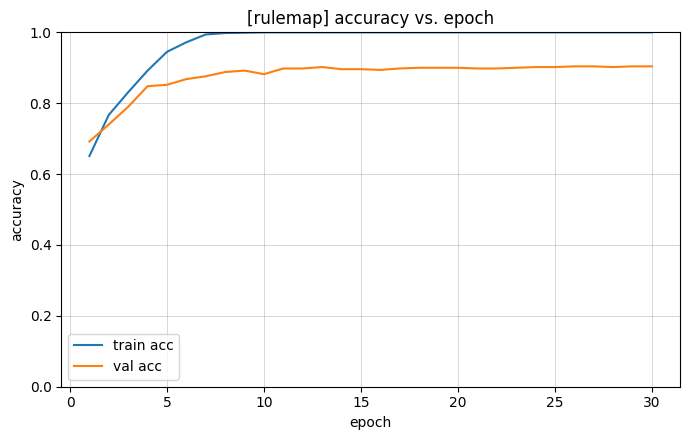

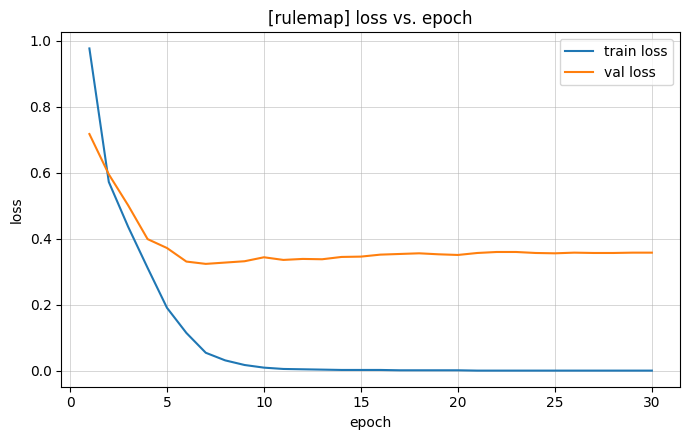

[TEST] by mode
mode	acc	loss
rulemap	0.926	0.233
random	0.408	2.657
logic	0.910	0.332
intermediate_case1	0.362	2.901
intermediate_case2	0.338	3.041

Training on single mode: random
[Epoch 01] train acc=0.284 loss=1.381 | val acc=0.336 loss=1.366
[Epoch 02] train acc=0.394 loss=1.327 | val acc=0.432 loss=1.316
[Epoch 03] train acc=0.561 loss=1.177 | val acc=0.554 loss=1.131
[Epoch 04] train acc=0.732 loss=0.855 | val acc=0.664 loss=0.897
[Epoch 05] train acc=0.820 loss=0.563 | val acc=0.698 loss=0.764
[Epoch 06] train acc=0.881 loss=0.381 | val acc=0.714 loss=0.723
[Epoch 07] train acc=0.937 loss=0.242 | val acc=0.734 loss=0.760
[Epoch 08] train acc=0.968 loss=0.147 | val acc=0.726 loss=0.824
[Epoch 09] train acc=0.986 loss=0.079 | val acc=0.730 loss=0.839
[Epoch 10] train acc=0.997 loss=0.039 | val acc=0.744 loss=0.922
[Epoch 11] train acc=1.000 loss=0.018 | val acc=0.744 loss=0.947
[Epoch 12] train acc=0.999 loss=0.011 | val acc=0.748 loss=0.967
[Epoch 13] train acc=1.000 loss=0.009 |

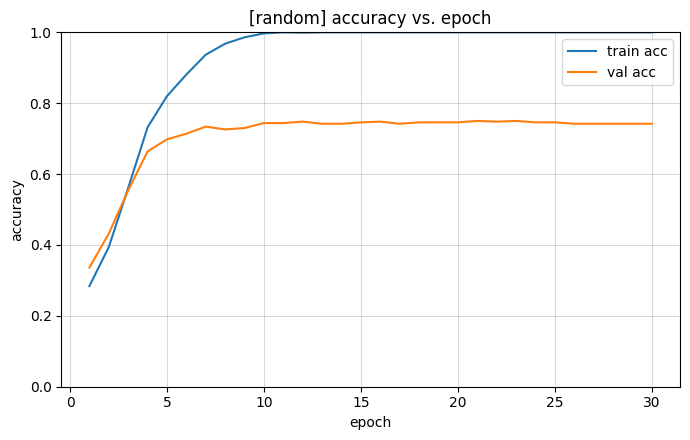

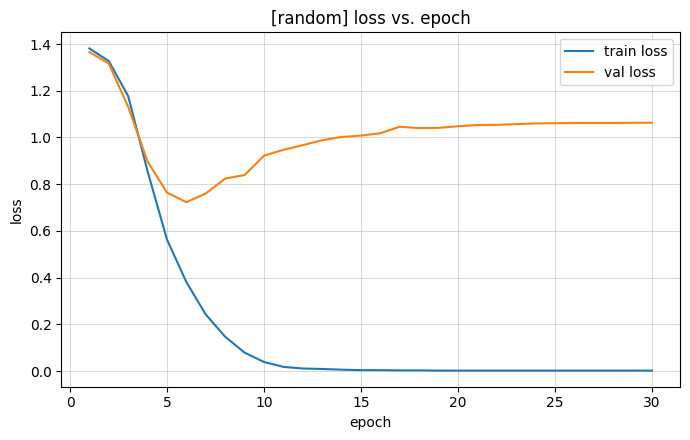

[TEST] by mode
mode	acc	loss
rulemap	0.768	0.869
random	0.722	1.292
logic	0.816	0.722
intermediate_case1	0.612	1.596
intermediate_case2	0.530	1.850

Training on single mode: logic
[Epoch 01] train acc=0.785 loss=0.835 | val acc=0.902 loss=0.343
[Epoch 02] train acc=0.925 loss=0.234 | val acc=0.946 loss=0.179
[Epoch 03] train acc=0.958 loss=0.125 | val acc=0.956 loss=0.106
[Epoch 04] train acc=0.984 loss=0.055 | val acc=0.988 loss=0.045
[Epoch 05] train acc=0.997 loss=0.024 | val acc=0.994 loss=0.029
[Epoch 06] train acc=1.000 loss=0.010 | val acc=0.994 loss=0.019
[Epoch 07] train acc=1.000 loss=0.006 | val acc=0.998 loss=0.016
[Epoch 08] train acc=1.000 loss=0.003 | val acc=0.996 loss=0.013
[Epoch 09] train acc=1.000 loss=0.003 | val acc=0.996 loss=0.011
[Epoch 10] train acc=1.000 loss=0.002 | val acc=0.998 loss=0.009
[Epoch 11] train acc=1.000 loss=0.001 | val acc=0.998 loss=0.009
[Epoch 12] train acc=1.000 loss=0.001 | val acc=0.996 loss=0.009
[Epoch 13] train acc=1.000 loss=0.001 | 

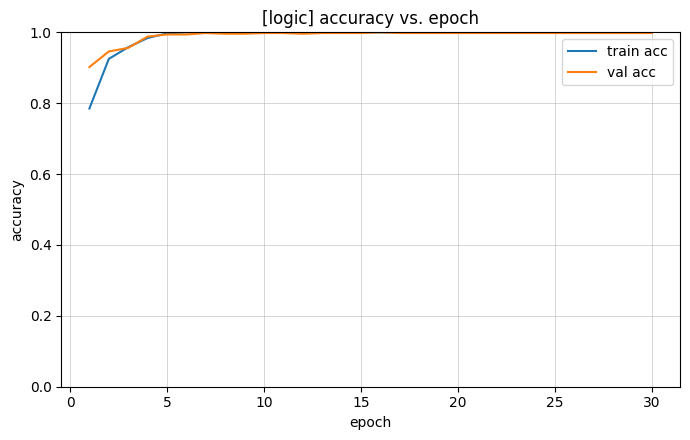

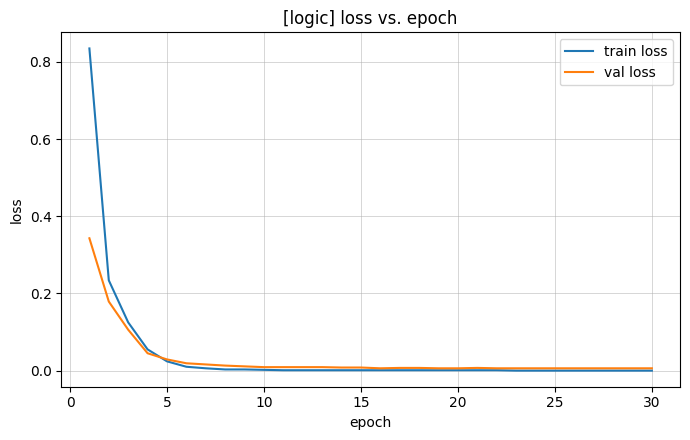

[TEST] by mode
mode	acc	loss
rulemap	0.758	0.896
random	0.340	2.816
logic	0.990	0.023
intermediate_case1	0.334	2.973
intermediate_case2	0.332	2.907

Training on single mode: intermediate_case1
[Epoch 01] train acc=0.276 loss=1.384 | val acc=0.278 loss=1.383
[Epoch 02] train acc=0.336 loss=1.358 | val acc=0.300 loss=1.368
[Epoch 03] train acc=0.420 loss=1.306 | val acc=0.364 loss=1.334
[Epoch 04] train acc=0.533 loss=1.181 | val acc=0.436 loss=1.249
[Epoch 05] train acc=0.651 loss=0.986 | val acc=0.512 loss=1.134
[Epoch 06] train acc=0.762 loss=0.740 | val acc=0.584 loss=1.027
[Epoch 07] train acc=0.840 loss=0.530 | val acc=0.630 loss=0.966
[Epoch 08] train acc=0.898 loss=0.358 | val acc=0.620 loss=0.943
[Epoch 09] train acc=0.951 loss=0.223 | val acc=0.630 loss=0.950
[Epoch 10] train acc=0.975 loss=0.131 | val acc=0.650 loss=1.016
[Epoch 11] train acc=0.992 loss=0.071 | val acc=0.666 loss=1.041
[Epoch 12] train acc=0.998 loss=0.035 | val acc=0.660 loss=1.107
[Epoch 13] train acc=1.000 

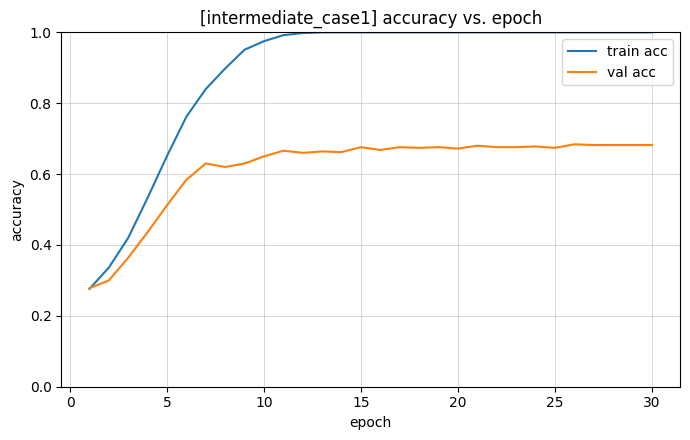

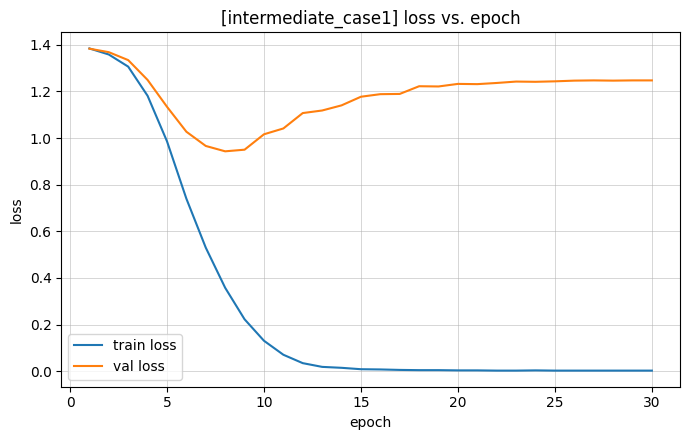

[TEST] by mode
mode	acc	loss
rulemap	0.778	0.944
random	0.718	1.358
logic	0.826	0.601
intermediate_case1	0.620	1.472
intermediate_case2	0.604	1.707

Training on single mode: intermediate_case2
[Epoch 01] train acc=0.309 loss=1.371 | val acc=0.380 loss=1.342
[Epoch 02] train acc=0.410 loss=1.298 | val acc=0.430 loss=1.278
[Epoch 03] train acc=0.504 loss=1.194 | val acc=0.538 loss=1.146
[Epoch 04] train acc=0.618 loss=1.009 | val acc=0.646 loss=0.937
[Epoch 05] train acc=0.724 loss=0.781 | val acc=0.734 loss=0.722
[Epoch 06] train acc=0.810 loss=0.576 | val acc=0.812 loss=0.553
[Epoch 07] train acc=0.886 loss=0.388 | val acc=0.846 loss=0.418
[Epoch 08] train acc=0.937 loss=0.242 | val acc=0.878 loss=0.345
[Epoch 09] train acc=0.971 loss=0.140 | val acc=0.894 loss=0.287
[Epoch 10] train acc=0.989 loss=0.069 | val acc=0.906 loss=0.244
[Epoch 11] train acc=0.992 loss=0.039 | val acc=0.914 loss=0.219
[Epoch 12] train acc=0.998 loss=0.023 | val acc=0.918 loss=0.213
[Epoch 13] train acc=0.999 

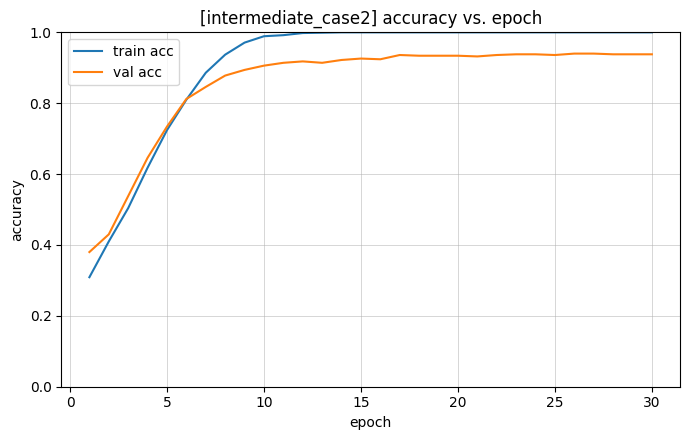

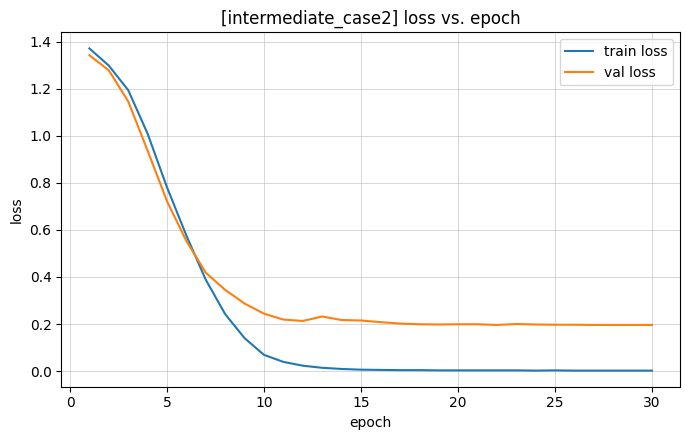

[TEST] by mode
mode	acc	loss
rulemap	0.652	1.521
random	0.628	1.861
logic	0.700	1.239
intermediate_case1	0.594	2.093
intermediate_case2	0.688	1.388


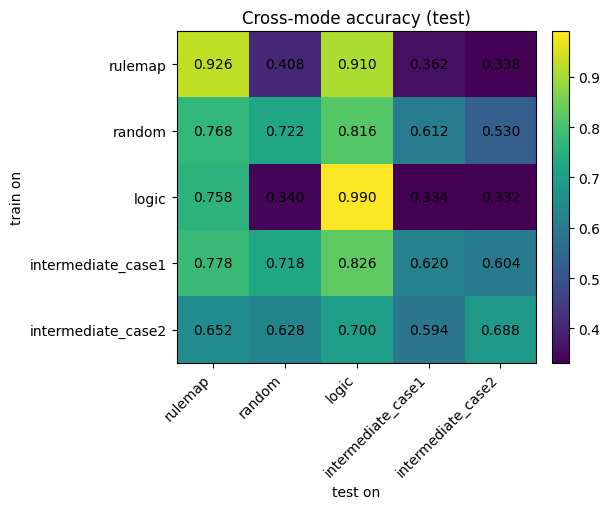

In [ ]:

cfg = TrainConfig(
    data_root=Path("/Users/Jer_ry/Desktop/scripts"),
    sim_name="sim1",
    mode="rulemap",
    batch_size=64,
    max_epochs=30,
    d_model=128, nhead=8, n_layers=2, dim_ff=1024, dropout=0.2, e_char_dim=64,
    add_cls=True, pad_id=576, cls_id=577,
)
transfer_mat = run_per_mode_bench_inline(cfg)
